# Term Deposit Marketing - An Apziva Project

# Modeling

By Samuel Alter

Apziva: G3SuQYZYrFt9dwF3

## Project Overview

Using phone call data from a European bank, this project will be building a model that predicts if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

### Goals

The startup is hoping that I can **achieve ≥81% accuracy** using a 5-fold cross validation strategy, taking the average performance score.

Bonus goals include:
* Determining which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

### The dataset

Using phone call data from a European bank, this project will be building models that predict if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

The dataset consists of the following columns:
* `age`
  * Numeric
  * The age of the customer
* `job`
  * Categorical
  * The job category of the customer
* `marital`
  * Categorical
  * Whether the customer is married
* `education`
  * Categorical
  * The customer's level of education
* `default`
  * Binary
  * If the customer has credit in default or not
* `balance`
  * Numeric
  * Average yearly balance in Euros
* `housing`
  * Binary
  * If the customer has a housing loan or not
* `loan`
  * Binary
  * If the customer has a personal loan
* `contact`
  * Categorical
  * The type of contact communication
* `day`
  * Numeric
  * Last contact day of the month
* `month`
  * Categorical
  * Last contact month of the year
* `duration`
  * Numeric
  * Duration of the last phone call with the customer
* `campaign`
  * Numeric
  * The number of contacts performed during this campaign and for this client, which includes the last contact

The final column, `y`, is the target of the dataset and shows whether the client subscribed to a term deposit.

## Imports and Helper Functions

In [252]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
import threading
from datetime import datetime
# from contextlib import contextmanager
from timeit import default_timer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
# from pycaret.classification import setup,compare_models,create_model,plot_model,evaluate_model
# from pycaret.regression import *

# from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import sklearn.lda.LDA as LDA # <-- this is throwing the ModuleNotFoundError

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import  accuracy_score,recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from collections import defaultdict

import shap

In [4]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [5]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    SOURCE: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [6]:
seed=rand_gen()
seed

4436

In [7]:
test_size=0.2
test_size

0.2

In [8]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x1620093C0

In [9]:
import json
from pathlib import Path
import inspect

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [10]:
# read in data
df=pd.read_csv('../data/2_data.csv')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no


## Goals recap

To achieve this project's goals, we have to run models. As a reminder, this project is aiming to predict customer behavior. Specifically, we are training models to determine if a customer will buy a term deposit loan.

We are aiming to achieve ≥81% accuracy with the modeling
  * Use a 5-fold cross validation strategy and take the average performance score.

Bonus goals include:
* Determine which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

## Will a Customer Receive a Loan?
`AutoSklearn` to  `Optuna` to `scikit-learn`: the Modeling Workflow

I will first use [`AutoSklearn`](#https://automl.github.io/auto-sklearn/master/#) to help me explore the ML algorithm landscape to identify the best-performing models for this particular dataset.

In order to find the best hyperparameters for our modeling, I will use [`Optuna`](#https://optuna.readthedocs.io/en/stable/index.html). This is similar to other frameworks like [`Hyperopt`](#http://hyperopt.github.io/hyperopt/), which are designed to quickly and efficiently find the best hyperparameters for your dataset.

Finally, we will use `sklearn` to build the final, optimized model.

### Notes on project setup:

We want to help the bank understand which customers are most likely to purchase the financial product. Knowing this would save the bank time and money. The dataset that we were given consists of demographic (and banking) data (like `age`,`job`,`marital`,and `balance`) as well as campaign-specific information (like `contact`,`day`,and `duration`).

*Demographic and Banking Data*
* `age`
* `job`
* `marital`
* `education`
* `default`
* `balance`
* `housing`
* `loan`

*Campaign-Specific Data*
* `contact`
* `day`
* `month`
* `duration`
* `campaign`

*Target Feature*
* `y`

We want to build a three-layered ML system that helps answer the project goals:
1. Understand which kinds of customers that they should call
 1. I will **not** give the model access to the campaign call data
1. After the initial calls, understand which customers the company should keep calling
 1. Give the model access to the campaign call data
1. Build a model using unsupervised learning to learn about clusters of customers in the dataset

**Layer 1**:  

Use `X_1` to model which customers to make calls to. We are training a model that does not know any call data, so this is *before* making calls.

**Layer 2**:  

Use the full `X` dataset (for clarity in its use in the layer flow, we'll be using `X_2` to model which customers the company should keep calling.

**Layer 3**:  

Use unsupervised learning to uncover how the customers are grouped.

### Setup X

In [211]:
dbd=[ # demographic and banking data
    'age',
    'job',
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan'
]

csd=[ # campaign-specific data
    'contact',
    'day',
    'month',
    'duration',
    'campaign'
]

`_1` refers to the first layer of the model, consisting of demographic and banking data, not including data related to the campaign. This simulates new customers that haven't received a call yet. This helps answer the main question of the project, namely to train a model that predicts which customer will receive a loan.

In [212]:
X_1=df[[col for col in df.columns if col != 'y' and col not in csd]]
y=df['y']
y=y.map({'yes':1,'no':0})

`_2` refers to the second layer of the model, consisting of all columns. This helps answer the first bonus question of the project, which is to determine which customers the bank should prioritize calling to: those most likely to receive a loan.

In [13]:
X_2=df[[col for col in df.columns if col != 'y']]

`_3` refers to the third layer of the model, consisting of all columns. This helps answer the another bonus question: can we train an unsuperived learning model that groups the customers into categories?

In [14]:
X_3=df[[col for col in df.columns if col != 'y']]

In [15]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


Make function to automate the training of the AutoSklearn pipeline:

In [16]:
def detectCatCont(X,verbose=False):
    '''
    Helper function for detecting categorical and continuous
    features in a dataset. It returns the categorical and
    continuous features as a tuple.
    '''

    # detect categorical and continuous features
    categorical_features = X.select_dtypes(
        include=['object', 'category']).columns.tolist()
    continuous_features = X.select_dtypes(
        include=['int64', 'float64']).columns.tolist()

    if verbose:
        print('Categorical and continuous features detected')

    return categorical_features,continuous_features

In [17]:
def defPreprocessor(categorical_features,continuous_features,verbose=False,custom_preprocessor=None):
    '''
    Helper function for returning a custom preprocessor for
    processing a dataframe, or one that is defined
    within the function. It returns the custom or
    function-created preprocessor.
    '''

    if custom_preprocessor is not None:
        if verbose:
            print('Using custom preprocessor')
        return custom_preprocessor

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), continuous_features)
        ]
    )

    if verbose:
        print('Preprocessor created')
        print('categorical_features:', categorical_features)
        print('continuous_features:', continuous_features)

    return preprocessor

In [18]:
def trainTestSplits(X,y,test_size,seed,verbose=False):
    '''
    Helper function that automates the train_test_split function within scikit-learn
    and returns them as a dictionary.
    '''

    # create train/test splits
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size=test_size, random_state=seed,stratify=y)

    if verbose:
        print('Training and testing splits created')

    splits={
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test
        }

    return splits

In [19]:
def defPipeline(time_for_task,seed,preprocessor,verbose=False):
    '''
    Helper function that creates the pipeline from a previously-defined
    preprocessor. Returns the pipeline.
    '''

    # Define Auto-sklearn classifier and pipeline
    automl = AutoSklearnClassifier(
        time_left_for_this_task=time_for_task,
        seed=seed
    )
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', automl)
        ]
    )

    if verbose:
        print('AutoSklearnClassifier and pipeline created')

    return pipeline

In [20]:
def evaluateModel(X_test,y_test,pipeline,verbose=False):
    '''
    Helper function that returns a tuple of predictions on
    the model and the accuracy.
    '''

    # evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if verbose:
        print(f"AutoSklearn accuracy:\n{accuracy*100:.2f}%")

    return y_pred,accuracy

In [21]:
def returnTopModels(pipe_path,score=0.9):
    '''
    Returns the most common classifiers achieving a mean_test_score of over 90% accuracy.
    This value can be changed in the function.
    '''

    # load pipeline and splits
    pipeline=joblib.load(pipe_path)

    # access the AutoSklearnClassifier from the pipeline
    automl_model = pipeline.named_steps['classifier']

    # access the cross-validation results
    cv_results=pd.DataFrame(automl_model.cv_results_)

    cv_results_=\
        cv_results[
            (cv_results['status'] == 'Success') & \
            (cv_results['mean_test_score']>score)
        ]\
    .sort_values(by='mean_test_score', ascending=False)

    cv_results_over90=cv_results_['param_classifier:__choice__'].value_counts()

    return cv_results_over90

In [22]:
def run_autosklearn_pipeline(X,y,seed,test_size,save_location,filename,verbose=False,time_for_task=3600,return_tops=True):
    '''
    Function that runs the AutoSklearnClassifier.
    Outputs a dictionary of the test_train_split'ed dataset ("splits")
    and the created pipeline object.

    It also returns the top-performing models
    that achieve an accuracy of over 90%.

    Arguments:
    X - the features dataset
    y - the target dataset
    seed - the random seed
    test_size - the test_size fraction for train_test_split
    save_location - the location where the splits and pipeline are located
    filename - what to call these two objects
    verbose - verbosity flag
    time_for_task - using the AutoSklearnClassifier default value

    Outputs:
    splits - a dictionary of X_train,X_test,y_train,y_test
    pipeline - the trained AutoSklearnClassifier pipeline
    '''

    categorical_features,continuous_features=detectCatCont(X,verbose)

    preprocessor=defPreprocessor(categorical_features,continuous_features,verbose)

    splits=trainTestSplits(X,y,test_size,seed,verbose)

    X_train=splits['X_train']
    X_test=splits['X_test']
    y_train=splits['y_train']
    y_test=splits['y_test']

    pipeline=defPipeline(time_for_task,seed,preprocessor,verbose)

    # start training
    if verbose:
        print(f"\nTraining the pipeline... (This may take up to {time_for_task//60} minutes)\n")
        print()
    pipeline.fit(X_train, y_train)

    # training complete
    if verbose:
        print("\nTraining complete.")

    y_pred,accuracy=evaluateModel(X_test,y_test,pipeline,verbose)

    pipe_path=f'{save_location+filename}'

    # save pipeline
    joblib.dump(pipeline,pipe_path)

    if verbose:
        print(f'saved pipeline here:\n{pipe_path}')

    splits_path=f'{save_location+filename}_splits'

    # save splits
    joblib.dump(splits,splits_path)

    if verbose:
        print(f'saved splits here:\n{splits_path}')

    if return_tops:
        cv_results_over90=returnTopModels(pipe_path)
        return splits,pipeline,cv_results_over90

    return splits,pipeline

### Layer 1: Using only the demographic and banking data

#### `AutoSklearn`

In [23]:
seed

4436

Note: I set the seed to a specific number because training the model takes time and I want to proceed with the rest of the project. This number was chosen randomly previously.

In [24]:
test_size

0.2

In [25]:
X_1.head(3)

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes


In [ ]:
# run function for layer_1
splits_1,pipeline_1,results_1=\
run_autosklearn_pipeline(X=X_1,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer1',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan']
continuous_features: ['age', 'balance']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)


[WARNING] [2024-08-22 03:13:33,051:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:13:33,765:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-08-22 03:14:17,146:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:14:31,188:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:20:32,566:Client-EnsembleBuilder] No mo

In [ ]:
# see top-performing models
results_1=returnTopModels('../joblib/2_pipeline_20240821_layer1')
results_1

random_forest          14
passive_aggressive      9
mlp                     5
adaboost                5
bernoulli_nb            4
k_nearest_neighbors     3
extra_trees             2
sgd                     1
liblinear_svc           1
lda                     1
Name: param_classifier:__choice__, dtype: int64

In [2]:
# load objects
pipeline_1=joblib.load('../joblib/2_pipeline_20240821_layer1')
splits_1=joblib.load('../joblib/2_pipeline_20240821_layer1_splits')

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estima

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
# determine accuracy of model
X_1_test=splits_1['X_test']
y_1_test=splits_1['y_test']

y_1_pred,accuracy_1=evaluateModel(X_test,y_test,pipeline_1,verbose=True)

AutoSklearn accuracy:
92.74%


/tmp/ipykernel_88/2902082143.py:80: RuntimeWarning: invalid value encountered in double_scalars
  f1_score  = 2*precision*recall / (precision + recall)


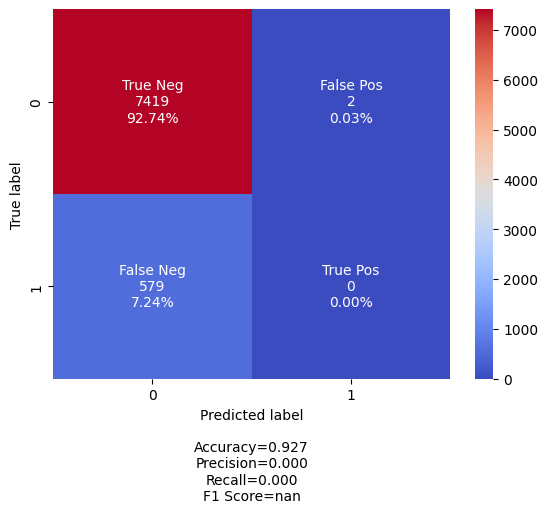

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_1=confusion_matrix(y_1_test,y_1_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_1,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_1_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.93      1.00      0.96      7421
         yes       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



Although we are able to get great accuracy for class 0 ('no'), we were not able to get a good accuracy for class 1 ('yes').

## Modeling: Layer 1

### Prepare Dataset for Modeling

Split data into training, validation, and testing sets:

In [213]:
data=pd.concat([X_1,y],axis=1)
data

,age,job,marital,education,default,balance,housing,loan,y
0,58,management,married,tertiary,no,2143,yes,no,0
1,44,technician,single,secondary,no,29,yes,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0
3,47,blue-collar,married,unknown,no,1506,yes,no,0
4,33,unknown,single,unknown,no,1,no,no,0
...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,0
39996,30,management,single,tertiary,no,3340,no,no,1
39997,54,admin,divorced,secondary,no,200,no,no,1
39998,34,management,married,tertiary,no,1047,no,no,0


In [214]:
train,temp=train_test_split(data,test_size=0.4,random_state=seed)
val,test=train_test_split(temp,test_size=0.5,random_state=seed)

In [215]:
print(f'''
{train.shape}
{temp.shape}
{val.shape}
{test.shape}
''')


(24000, 9)
(16000, 9)
(8000, 9)
(8000, 9)



In [233]:
train

,age,job,marital,education,default,balance,housing,loan,y
17472,29,management,single,tertiary,no,1895,no,no,0
26759,32,blue-collar,single,secondary,no,2696,yes,no,0
37325,45,blue-collar,married,tertiary,no,23,yes,yes,0
1482,37,blue-collar,divorced,secondary,no,48,yes,no,0
37158,34,blue-collar,married,secondary,no,496,yes,no,1
...,...,...,...,...,...,...,...,...,...
11598,38,blue-collar,married,secondary,no,1403,no,no,0
19466,52,entrepreneur,married,secondary,no,0,no,no,0
18793,36,blue-collar,married,secondary,no,1550,no,no,0
24874,59,entrepreneur,married,primary,no,222,no,no,0


In [216]:
# view breakdown of each class
listo=[train,temp,val,test]
for item in listo:
    print(Counter(item['y']))

Counter({0: 22272, 1: 1728})
Counter({0: 14832, 1: 1168})
Counter({0: 7430, 1: 570})
Counter({0: 7402, 1: 598})


Create function to speed up preparing data for modeling going forward:

In [255]:
cat_cols = X_1.select_dtypes(include='object').columns
num_cols = X_1.select_dtypes(exclude='object').columns

num_cols

Index(['age', 'balance'], dtype='object')

In [262]:
def ml_workflow(data,target_column_name,cat_cols,random_state,classifiers,verbose=1,train_size=0.4,test_size=0.5):
    '''
    Complete ML pipeline: preprocess data, cross_validate models, fit, and evaluate
    '''
    
    # split data into train, validation, and test sets
    train,temp=train_test_split(data,test_size=train_size,random_state=random_state)
    val,test=train_test_split(temp,test_size=test_size,random_state=random_state)
    if verbose=1:
        print('Data is split into train, val, and test sets')
    if verbose>1:
        print(f'''
    Data is split into train (shape:{train.shape}), 
    val (shape:{val.shape}), and 
    test (shape:{test.shape}) sets''')

    # separate target from features
    X_train,y_train=train.drop(columns=[target_column_name]),train[target_column_name]
    X_val,y_val=val.drop(columns=[target_column_name]),val[target_column_name]
    X_test,y_test=test.drop(columns=[target_column_name]),test[target_column_name]
    if verbose=1:
        print('Separated target column from features')
    if verbose>1:
        print(f'''
        X_train shape: {X_train.shape}
        y_train shape: {y_train.shape}
        X_val shape: {X_val.shape}
        y_val shape: {y_val.shape}
        X_test shape: {X_test.shape}
        y_test shape: {y_test.shape}
        ''')
    
    # define numerical columns for scaling
    num_cols=[col for col in X_train.columns if col not in cat_cols]
    if verbose=1:
        print('Defined numerical columns')
    if verbose>1:
        print(f'Numerical columns: {num_cols}')

    # Define preprocessing pipeline
    preprocessor=ColumnTransformer(
        transformers=[
            ('num',StandardScaler(),num_cols),
            ('cat',OneHotEncoder(handle_unknown='ignore'),cat_cols)
        ]
    )
    if verbose=1:
        print('Preprocessor created')
    if verbose>1:
        print(f'Preprocessor: {preprocessor}')
    
    # define classifiers
    classifiers=classifiers
    if verbose=1:
        print('Classifiers have been defined')
    if verbose>1:
        print(f'Classifiers: {classifiers}')
    
    # store cross-validation scores
    cv_scores={}

    # Perform cross-validation for each model
    for name, model in classifiers.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        scores = cross_validate(pipe, X_train, y_train, cv=cv, 
                                scoring=['accuracy', 'precision', 'recall', 'f1'])
        
        print(f"\n{name} Cross-Validation Scores:")
        print(f"Accuracy: {np.mean(scores['test_accuracy']) * 100:.2f}%")
        print(f"Recall: {np.mean(scores['test_recall']) * 100:.2f}%")
        cv_scores[name] = scores

    # Find the best models based on accuracy and recall
    best_accuracy_model = max(cv_scores, key=lambda x: np.mean(cv_scores[x]['test_accuracy']))
    best_recall_model = max(cv_scores, key=lambda x: np.mean(cv_scores[x]['test_recall']))

    print(f"\nBest Accuracy Model: {best_accuracy_model}")
    print(f"Best Recall Model: {best_recall_model}")

    # Fit the best models on the full training set
    fitted_models = {}
    for name, model in classifiers.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        pipe.fit(X_train, y_train)
        fitted_models[name] = pipe

    # Evaluate models on the validation set
    print("\nValidation Set Evaluation:")
    for name, model in fitted_models.items():
        y_pred = model.predict(X_val)
        print(f"\n{name} Validation Results:")
        print(f"Accuracy: {accuracy_score(y_val, y_pred) * 100:.2f}%")
        print(f"Recall: {recall_score(y_val, y_pred, average='weighted') * 100:.2f}%")
        print(classification_report(y_val, y_pred))

    # Evaluate models on the test set
    print("\nTest Set Evaluation:")
    for name, model in fitted_models.items():
        y_pred = model.predict(X_test)
        print(f"\n{name} Test Results:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print(f"Recall: {recall_score(y_test, y_pred, average='weighted') * 100:.2f}%")
        print(classification_report(y_test, y_pred))

In [ ]:
def mlProcess:
    # preprocessing step (OneHotEncoding for categorical, scaling for numeric)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ]
    )

    # Create a pipeline that includes preprocessing and classifier
    def create_pipeline(model):
        return Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Fit each model using the pipeline
    fitted_model = {}

In [261]:
# preprocessing step (OneHotEncoding for categorical, scaling for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Create a pipeline that includes preprocessing and classifier
def create_pipeline(model):
    return Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

# Fit each model using the pipeline
fitted_model = {}

for name, model in classifier_map.items():
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    fitted_model[name] = pipeline

# Model evaluation function
def model_eval(models, X, y):
    for name, model in models.items():
        y_pred = model.predict(X)  # Predict on validation data
        accuracy = accuracy_score(y, y_pred)
        recall = recall_score(y, y_pred)

        print(f'''
        Model name: {name}
        Accuracy: {accuracy * 100:.2f}%
        Recall: {recall * 100:.2f}%
        Classification report:
        {classification_report(y, y_pred)}
        ''')

ValueError: A given column is not a column of the dataframe

In [ ]:
# Evaluate models on the validation data
model_eval(fitted_model, X_val, y_val)

In [256]:
def dummy_and_scale(data, target_column_name, cat_columns, scaler, drop_first=False, 
                    undersample=False, oversample=False):
    '''
    Function to dummify only categorical columns and scale numeric ones.
    '''
    # Separate target column
    X = data.drop(columns=[target_column_name])
    y = data[target_column_name]

    # Identify numerical columns to scale
    num_columns = [col for col in X.columns if col not in cat_columns]

    # Dummify only categorical columns
    X_cat = pd.get_dummies(X[cat_columns], drop_first=drop_first)

    # Scale numerical columns
    X_num_scaled = pd.DataFrame(scaler.fit_transform(X[num_columns]), 
                                columns=num_columns, 
                                index=X.index)

    # Combine scaled numerical and dummified categorical columns
    X_scaled = pd.concat([X_num_scaled, X_cat], axis=1)

    # Optional under/oversampling
    if undersample:
        rus = RandomUnderSampler()
        X_scaled, y = rus.fit_resample(X_scaled, y)

    if oversample:
        ros = RandomOverSampler()
        X_scaled, y = ros.fit_resample(X_scaled, y)

    # Concatenate scaled features and target column
    data_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

    return data_scaled, X_scaled, y

In [257]:
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')

In [237]:
train_scaled,X_train,y_train=dummy_and_scale(
    data=data,
    target_column_name='y',
    cat_columns=cat_cols,
    scaler=StandardScaler(),
    drop_first=True,
    oversample=True
)

In [238]:
# check to make sure it worked
Counter(train_scaled['y'])

Counter({0: 37104, 1: 37104})

### Cross Validation with 5 Folds

Define function to speed up model cross-validation process:

In [246]:
def crossValidate(model, folds, X_train, y_train, random_state,timer=False):
    '''
    Cross-validate and get scores for user-specified models.
    '''
    score_dict={}
    
    start_time=time.time()
    
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    
    # Perform cross-validation
    scores = cross_validate(model, X=X_train, y=y_train, cv=cv, scoring=scoring)

    # Use setdefault to safely access and initialize the model's scores
    score_dict.setdefault(model, {}).setdefault('accuracy', []).extend(scores['test_accuracy'])
    score_dict.setdefault(model, {}).setdefault('precision', []).extend(scores['test_precision'])
    score_dict.setdefault(model, {}).setdefault('recall', []).extend(scores['test_recall'])
    score_dict.setdefault(model, {}).setdefault('f1', []).extend(scores['test_f1'])
    
    # Print average scores
    print(f'\nModel: {model}')
    print(f'Average Accuracy: {scores["test_accuracy"].mean() * 100:.2f}%')
    print(f'Average Precision: {scores["test_precision"].mean() * 100:.2f}%')
    print(f'Average Recall: {scores["test_recall"].mean() * 100:.2f}%')
    print(f'Average F1 Score: {scores["test_f1"].mean() * 100:.2f}%')
    if timer:
        end_time=time.time()
        print(f'Elapsed time: {end_time-start_time:.2f} seconds') 
    print('-' * 20)
    
    return score_dict

In [247]:
classifier_map={
    'etc':ExtraTreeClassifier(random_state=seed),
    'xgb':XGBClassifier(random_state=seed),
    'dtc':DecisionTreeClassifier(random_state=seed),
    'rfc':RandomForestClassifier(random_state=seed),
    'lgb':LGBMClassifier(random_state=seed,verbose=-1),
    'lrx':LogisticRegression(random_state=seed)
}

In [248]:
cv_scores={}
for key in classifier_map.keys():
    cv_scores[key]=crossValidate(model=classifier_map[key],
                  folds=5,
                  X_train=X_train,
                  y_train=y_train,
                  random_state=seed,
                  timer=True)


Model: ExtraTreeClassifier(random_state=4436)
Average Accuracy: 95.39%
Average Precision: 91.62%
Average Recall: 99.92%
Average F1 Score: 95.59%
Elapsed time: 0.26 seconds
--------------------

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=4436, ...)
Average Accuracy: 77.20%
Average Precisi

In [249]:
# loop through results to extract best model and results
max_mean_recall=0
max_mean_accuracy=0
best_recall_model=None
best_accuracy_model=None

for model_name,model_data in cv_scores.items():
    
    scores=list(model_data.values())[0]
    
    mean_recall=np.mean(scores['recall'])
    mean_accuracy=np.mean(scores['accuracy'])
    
    # update max recall and corresponding model
    if mean_recall>max_mean_recall:
        max_mean_recall=mean_recall
        best_recall_model=model_name
        
    # update max accuracy and corresponding model
    if mean_accuracy>max_mean_accuracy:
        max_mean_accuracy=mean_accuracy
        best_accuracy_model=model_name
        
# print results
print(f'''
Model with max mean recall: {best_recall_model} 
Recall: {max_mean_recall*100:.2f}%''')
print(f'''
Model with max mean accuracy: {best_accuracy_model} 
Accuracy: {max_mean_accuracy*100:.2f}%''')


Model with max mean recall: rfc 
Recall: 99.93%

Model with max mean accuracy: rfc 
Accuracy: 96.56%


Using the training dataset, the best model is RandomForestClassifier with an average recall of almost 100%! The accuracy is also very high, at over 98%.

### Evaluate the models on the validation set

In [251]:
def model_fit(model,X,y):
    '''
    Fit the model on training data.
    '''
    model.fit(X,y)
    return model

fitted_model={}

# Fit each model and store in a dictionary
for name,model in classifier_map.items():
    fitted_model[name]=model_fit(model,X_train,y_train)

def model_eval(models,X,y):
    '''
    Evaluate fitted models on the validation data.
    '''
    for name,model in models.items():
        y_pred=model.predict(X)  # Predict on validation data
        accuracy=accuracy_score(y,y_pred)
        recall=recall_score(y,y_pred)

        print(f'''
        Model name: {name}
        Accuracy: {accuracy*100:.2f}%
        Recall: {recall*100:.2f}%
        Classification report:
        {classification_report(y,y_pred)}
        ''')

# Evaluate models on validation data
model_eval(fitted_model,X_val,y_val)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- default
- education
- housing
- job
- loan
- ...
Feature names seen at fit time, yet now missing:
- default_yes
- education_secondary
- education_tertiary
- education_unknown
- housing_yes
- ...


## Modeling: Layer 2

### Layer 2: Use the full X dataset to model which customers the bank should keep calling

In [ ]:
X_2.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1


In [ ]:
splits_2,pipeline_2,results_2=\
run_autosklearn_pipeline(X=X_2,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer2',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
continuous_features: ['age', 'balance', 'day', 'duration', 'campaign']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)




In [ ]:
results_2=returnTopModels('../joblib/2_pipeline_20240821_layer2')
results_2

random_forest          23
mlp                     5
liblinear_svc           3
k_nearest_neighbors     2
extra_trees             2
passive_aggressive      1
gaussian_nb             1
bernoulli_nb            1
Name: param_classifier:__choice__, dtype: int64

In [ ]:
pipeline_2=joblib.load('../joblib/2_pipeline_20240821_layer2')
splits_2=joblib.load('../joblib/2_pipeline_20240821_layer2_splits')

In [ ]:
X_2_test=splits_2['X_test']
y_2_test=splits_2['y_test']

y_2_pred,accuracy_2=evaluateModel(X_2_test,y_2_test,pipeline_2,verbose=True)

AutoSklearn accuracy:
93.77%


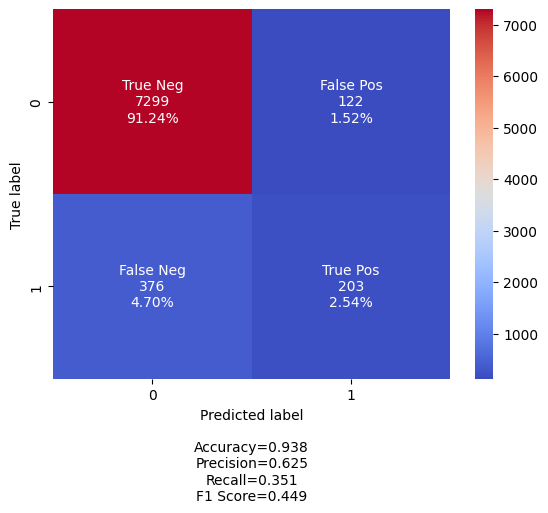

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_2=confusion_matrix(y_2_test,y_2_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_2,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_2_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.95      0.98      0.97      7421
         yes       0.62      0.35      0.45       579

    accuracy                           0.94      8000
   macro avg       0.79      0.67      0.71      8000
weighted avg       0.93      0.94      0.93      8000



This is also a great result.